In [ ]:
try:
    import tangelo
except ImportError:
    !pip install tangelo-gc

# Quantum Chemistry

Quantum chemistry aim to solve the Schrodïnger equation for many-electron molecules. As stated in the quantum mechanics postulates, the wavefunction $\Psi$ encodes all the information of the system. One who knows the electronic wavefunction of a molecular system can therefore predict measurement outcomes of an experiment. This is a highly valuable asset for academia and indutrial purposes to accelerate research of new drugs or functional materials. For instance, bioinspired molecules are an efficient way of quickly designing new materials while taking into account the million years of evolution that nature had to optmize a process. 

One difficult thing to do in the laboratory is changing the spin state of a compound during a chemical reaction. Nature circumvents this problem by using transition metals: the oxygen fixation is done by the heme biomolecule, where an Fe(II) atom is involved in the spin state change mechanism (see figure below) [[10.1074/jbc.M314007200](https://doi.org/10.1074/jbc.M314007200)].

![FeIIPorImO2 system](img/FeIIPorImO2.png "FeIIPorImO2 system")

Fully understanding the mechanism of this system, that is to say knowing the rate constants for all elementary reaction) would lead to valuable insights for the design of chemical catalysts. Achieving this goal would lead us forward one step closer to *making the world cleaner, healthier, and more sustainable*. This is one of the main application of quantum chemistry; however, the Schrodïnger equation shown below cannot be solved exactly for systems beyond one electron, i.e. all relevant chemical systems for the sciencitif community.

\begin{equation}
\hat{H} \Psi = E \Psi
\end{equation}

Where $\hat{H}$ is expressed in the first quantization form as

\begin{equation} \label{eq:H_first_quant}
\hat{H}_e = -\frac{\hbar^2}{2 m_e} \sum_i \nabla_i^2 -\frac{e^2}{4 \pi \epsilon_0} \sum_i \sum_A \frac{Z_A}{r_{iA}} + \frac{e^2}{4 \pi \epsilon_0} \sum_i \sum_{j>i} \frac{1}{r_{ij}}
\end{equation}

Or, in the second quantization formalism,

\begin{equation}
H = \sum_{pq}h_{pq} a_p^{\dagger}a_q + \frac{1}{2}\sum_{pqrs}h_{pqrs}a_p^{\dagger}a_r^{\dagger}a_s a_q
\end{equation}

For more information about the theory and methods in quantum chemistry, see the references at the end of this notebook. We will provide clues on how to choose input parameters for modelling molecules on quantum computers with [Tangelo](https://github.com/goodchemistryco/Tangelo). As quantum resources are sill scarsed, we will start from a stripped down version of the Heme system, the dioxygen molecule.

In [1]:
xyz = [
    ("O", (0., 0., 0.)),
    ("O", (0., 0., 1.21))
]

## Computation of the Mean-Field

Computation of the mean-field is usually the first step of all post Hartree-Fock approaches, which we will describe in  the [Consideration of Correlation Energy - Potential of Quantum Computing](#correlation_energy) section. The mean-field approaches impose the approximation where every electron in the system interacts with the total mean electron field in a self-consistent way. In other words, each electron does not explicitely interact with the other electrons. Depending on the molecular information, subject of the next section, different flavours of mean-field solution can be computed.

### Molecular Information

The chemical information is encapsulated in the `SecondQuantizedMolecule`. As the name suggests, the formalism used in Tangelo is the second quantization; however, the package is not restricted to this and data structures could be implemented in other formalism (like the first quantization).

When defining a molecule, one must consider the molecular properties. One of them is the total charge of the system, i.e. the difference between the number of electrons and the total nuclear charge (default value is 0). This is an important property when dealing with oxydo-reduction reactions where cations (deficit in electrons) and anions (surplus in electrons) could be involved. The other important quantities to specify is the spin, defined by the difference between the number of alpha and beta electrons (default value is 0). This ensure radical reactions could be handled: a spin of 0 ensures a restricted-shell molecule while a spin different from 0 characterizes an open-shell system.

In the next cell, the dioxygen molecule data structure is constructed. As you may know, the ground state of the dioxygen molecule is the triplet (spin=2) and neutral (q=0) molecule.

In [2]:
from tangelo import SecondQuantizedMolecule
o2_sto3g = SecondQuantizedMolecule(xyz, q=0, spin=2)
print(f"{o2_sto3g.n_active_mos} active molecular orbitals")
print(f"{o2_sto3g.n_active_electrons} active electrons")

8 active molecular orbitals
12 active electrons


In the next sections, the effect of those parameters on the quantum resources will be discussed. This will ensure that the users would be able to change those parameters for eventually contructing a chemical problem tractable for the available quantum hardware.

### Restricted vs Unrestricted  Hartree-Fock (RHF/ROHF vs UHF)

The mean-field solution is automatically computed when the `SecondQuantizedMolecule` is created. With the provided spin, it computes the relevant mean-field, that is to say the Restricted or Restricted Open-Shell Hatree-Fock solution (RH or ROHF). Using those methods, the spin-orbitals are treated by pairs, so each molecular orbital accepts two electrons. The unrestricted Hartree-Fock (UHF) mean-field calculation, where the spin-orbitals are considered individually, is another method that usually results in lower energies for open-shell systems. However, this last one is not implemented yet in Tangelo. Further theory and implementation details about the RHF, ROHF and UHF algorithms can be found in [Szabo & Ostlund].

### Choice of the Basis Set

The choice of the basis set is an important step in quantum chemistry. As the many-electron atoms and molecules cannot be treated exactly via the Schrodïnger equation, the orbitals for those problems are expressed as a Linear Combination of Atomic Orbitals (LCAO). These atomic orbitals are the analytical solution of the hydrogen atom [McQuarrie Chapter 7 and Engel Chapter 9]. Here are the functions, in spherical coordinates, of the few first hydrogen atom orbitals, namely the 1s, 2s and 2pz orbitals:

$$
\begin{align*}
    \psi_{100} &= \frac{1}{\sqrt{\pi}} \left( \frac{1}{a_0} \right)^{3/2} e^{-r/a_0} \\
    \psi_{200} &= \frac{1}{4\sqrt{2\pi}} \left( \frac{1}{a_0} \right)^{3/2} \left( 2-\frac{r}{a_0} \right) e^{-r/2a_0} \\
    \psi_{210} &= \frac{1}{4\sqrt{2\pi}} \left( \frac{1}{a_0} \right)^{3/2} \frac{r}{a_0} e^{-r/2a_0} \cos{\theta} \\
    &\vdots
\end{align*}
$$

where $\psi_{n l m_l}$ and $a_0$  are respectively the wavefunction for the atomic orbital with the principal quantum number $n$, the angular momentum quantum number $l$ and the magnetic quantum number $m_l$ and the Bohr radius. We can see that the atomic orbitals have an exponential term ($e^{-r/a_0}$). One can therefore choose to use a basis set based on decreasing exponential terms ($e^{-\alpha r}$, where $\alpha$ is a fitting constant). In early quantum chemistry, this scheme was refered to *Slater Type Orbitals* (STOs). With the increase of computational resources, the use of gaussian functions was popularized in the basis sets. In comparison with STOs, it is much more efficient to compute the numerous overlap integrals (needed in a quantum chemistry problem) with gaussian function ($e^{-\alpha r^2}$). This is the origin of *Gaussian Type Orbitals* (GTOs) wavefunction.

State-of-the-art basis sets regroup many gaussian terms. In the Pople notation:
- The hyphen symbol (-) separates the reference to core and valence orbitals;
- The figures represent the number of primitive gaussians in a function;
- The number of figures represents the number of functions for each atomic orbital (zeta $\zeta$);
- The letter G refers to the use of gaussian functions. 

As an example, the `3-21G` double zeta basis set uses three gaussian primitives for every core orbitals and a set two plus one gaussian primitives for the valence orbitals. More information can be found in this [link](https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/11%3A_Computational_Quantum_Chemistry/11.02%3A_Gaussian_Basis_Sets). LCAO coefficients, used to construct molecular obtitals, are obtained through the minimization of the total energy and the account of the variational principle.

Here are basis set examples used in quantum chemistry.

In [3]:
basis_sets = [
    "STO-3G",       # Simple zeta, minimal basis.
    "3-21G",        # Double zeta.
    "6-31G",        # Double zeta with more gaussian primitives.
    "6-31G(d,p)",   # Polarization functions (+ 5 d-orbitals for all atoms except H, +3 p-orbitals for H atoms) added.
    "6-311G(d,p)",  # Triple zeta with polarization functions.
    "6-311+G(d,p)", # Triple zeta with polarization functions and diffuse functions.
    "cc-pvqz",      # Quadruple zeta.
    "cc-pv5z"       # Quintuple zeta.
]

The wavefunction for a molecule is an approximation when using a finite basis,

$$
\Phi_{\text{approx}} = \sum_{i=0}^N c_i |i \rangle
$$

By the variational principle, considering $\Phi_{\text{approx}}$ is normalized, the approximated energy is greater or equals to the true ground-state energy.

$$
\langle \Phi_{\text{approx}} | \hat{H} | \Phi_{\text{approx}} \rangle = \epsilon_{\text{approx}} \geq  \epsilon_{\text{true}}
$$

With an infinite basis set, the approximation should be close to the real wavefunction.

$$
\Phi_{\text{approx}} = \sum_{i=0}^{\infty} c_i |i \rangle \approx \Psi_{\text{true}}
$$

We should retrieve the true energy $\epsilon_{\text{true}}$ from the computation. However, increasing the basis set size has the effect of increasing the number of parameters to optimize, therefore extending the needed computational resources in space (amount of memory) and in time (compute time). As we shall see shortly, it is often a good idea to balance the basis set size to optimize the time to solution versus the wanted precision ($|\epsilon_{\text{approx}} -  \epsilon_{\text{true}}|$), as the gain in precision reduces as the basis sets gets bigger.

A full list of available basis set supported in PySCF(https://pyscf.org/) (therefore also in Tangelo) are available in this [link](https://pyscf.org/_modules/pyscf/gto/basis.html). Also, the [Basis Set Exchange](https://www.basissetexchange.org/) initiative hosts a collection of basis for every atom in the periodic table. With this constantly increasing number of basis available for the community, we aknowledge the basis choice can be a challenging task. The theory states that an infinite basis is the way of getting the true wavefunction. Nevertheless, it is not something possible to work with most of the time and one may prefer a basis on a per-problem feature. 

Here are some tips and tricks for the basis choice depending on the modelled system. 
- As a rule of thumb, a double zeta (e.g. `6-31G` or `cc-pvdz`) is the minimum basis size to get semi-quantitative energies. 
- For molecules with a high electronegativity difference between atoms, adding polarization functions (e.g. `6-31G**` or `6-31G(d,p)`) might be a necessity. 
- Diffuse functions (e.g. `6-31G+(d,p)`) should be part of the computation of anions. Diffusion functions are functions with small coefficients (small $\alpha$ in $e^{-\alpha r^2}$) that can fit the electronic density far from the nucleus.
- Effective Core Potential (ECP) basis sets are needed when dealing with heavier atoms with relativistic and non-trivial effects (e.g. iodine atom is often modelled in the `LANDL2DZ` basis).

In the next cell, we demonstrate the effect of the basis on the energy and time to solution.

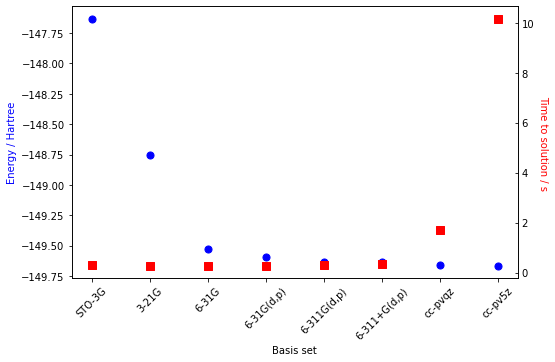

In [4]:
import time
import matplotlib.pyplot as plt

# Getting the energy vs basis set.
mf_energies = list()
mf_times = list()

# Performing a Mean-Field calculation for every basis set.
for bs in basis_sets:
    
    # Measuring execution time.
    start = time.time()
    scan_basis_mol = SecondQuantizedMolecule(xyz, q=0, spin=2, basis=bs)
    end = time.time()
    
    mf_energies.append(scan_basis_mol.mf_energy)
    mf_times.append(end-start)

# Creating the matplotlib figure.
fig, ax = plt.subplots(figsize=(8,5))

# Plotting the energies.
ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
ax.set_xlabel("Basis set")
ax.set_ylabel("Energy / Hartree", color="b")
ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# Plotting the time to solution.
ax_time = ax.twinx()
ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# Showing the graph.
plt.tick_params(axis="both", direction="in")
plt.show()

We see in the previous graph that increasing the basis complexity brings the energy eigenvalue closer to the true Hartree-Fock energy. This trend can be generalized to other methods as well, like CCSD, MP2, FCI, ... although the time to solution would be longer for those post Hatree-Fock approaches. The take-home message is that even if an infite basis is required to converged to the true energy, there are diminishing returns at some point, especially when considering the time required for the calculation. In our case, `6-311G(d,p)` may appear as a good choice in terms of accuraccy and computational time.

## Consideration of Correlation Energy - Potential of Quantum Computing
<a id="correlation_energy"></a>

Post Hatree-Fock methods are meant to consider the electronic correlation energy. In many textbooks, the correlation energy is defined as

$$
\epsilon_{\text{corr}} = \epsilon - \epsilon_{\text{HF}}
$$

Where $\epsilon$ and $\epsilon_{\text{HF}}$ are the computed energy and the Hartree-Fock energy, respectively. This correlation energy can be split into two categories: static and dynamical correlation. To consider the former, one should use multi-configuration approaches. The latter can be tackled with post Hatree-Fock methods with a single reference state, like Configuration Interaction (CI), Coupled-Cluster (CC) or perturbative methods (MP2, MP3, ...). Going beyond this explanation is out of scope for this notebook, therefore we encourage the user to read on the subject in [Szabo & Ostlund].

We saw in the previous section that the `6-311G(d,p)` may be a good compromise to compute the O2 ground state. In this basis, the dioxygen molecule is described by 72 bases (spinorbitals) and 16 electrons. To get the gihgest fidelity wavefunction versus the true wavefunction with the Full Configuration Interaction solution, we would need ${72 \choose 16} \approx 3 \times 10^{13}$ configurations. By representing each configuration with a single byte (for the sake of this example), one would need 4.11 petabytes to store the full wavefunction of the dioxygen molecule. This effect is amplified when dealing with relevant industrial molecules like organometallic complexes or proteins. Going through the classical formalism of quantum chemistry is therefore not a viable long-term solution.

With the occupation transformation (Jordan-Wigner) from the chemical problem to a qubit basis, this problem vanishes. In fact, by leveraging the quantum superposition principle, it is possible to map the O2 triplet ground state to 72 qubits (empty and filled spinorbitals are mapped to the $|0\rangle$ and $|1\rangle$ states, respectively). This fact is behind the emerging enthusiasm of the quantum computing community for chemistry applications. We should note that even if this space limitation is mitigated, no consensus is established for the time complexity (correlated to the number of gates required to construct a molecular wavefunction) [[arXiv:2009.12472](https://doi.org/10.48550/arXiv.2009.12472)].

## Resource reduction

Resource reduction refers to lowering of the computational requirements to run an algorithm. In conventional computing, this translates to less memory requirements and faster runtimes. The reduction of the number of qubits and shallower quantum circuits are the equivalent in quantum computing.

Our starting example will be the O2 molecule in the `6-311G(d,p)` basis. We will focus our attention on the strategies to reduce the resource requirements before the algorithm definition. For other strategies, like switching the ansatz definition or fragmenting the molecules into many smaller fragments (problem decomposition), the user should refer to the relevant notebooks in the [Tangelo examples](https://github.com/goodchemistryco/Tangelo/tree/develop/examples) folder.

In [4]:
o2_6311gdp = SecondQuantizedMolecule(xyz, q=0, spin=2, basis="6-311G(d,p)", frozen_orbitals=None)
print(f"{o2_6311gdp.n_active_mos} active molecular orbitals")
print(f"{o2_6311gdp.n_active_electrons} active electrons")

36 active molecular orbitals
16 active electrons


The O2 molecule in the 6-311G(d,p) basis would require 72 qubits and inherently a deep quantum circuit. Decreasing the number of qubits required provides the first indirect way of constructing shallower circuits. The two methods discussed shortly are the reduction of the active space and the consideration of molecular symmetries.

### Active Space Selection

Active space selection is a trivial way to reduce the number of qubits by neglecting molecular orbitals in the post-Hartree-Fock calculation. Although applying this method is trivial, choosing which molecular orbitals to freeze is not. While there is no general algorithm to perform that operation, one can evaluate which orbitals to freeze by first printing the molecular orbital eigenvalues.

In [6]:
o2_6311gdp.mo_energies

NPArrayWithTag([-20.72930408, -20.72835731,  -1.65179434,  -1.09915047,
                 -0.73361153,  -0.70373253,  -0.70373253,  -0.21364599,
                 -0.21364599,   0.45202177,   0.9186063 ,   0.9186063 ,
                  0.92995258,   0.97314007,   1.02843356,   1.03307671,
                  1.03307671,   1.51283558,   2.5973314 ,   2.5973314 ,
                  2.93328917,   2.93328917,   3.22254778,   3.22254778,
                  3.2344147 ,   3.83879572,   3.83879572,   4.21285284,
                  5.08275099,   5.08275099,   5.21282539,   5.38969197,
                  5.38969197,   6.540027  ,  51.17808751,  51.36755659])

One way of viewing this is to only consider frontier orbitals and their neighbors. The effect on the total energy when only considering a subsset of the full active space might be small. For example, freezing low-lying occupied molecular orbitals is known as the *frozen-core approximation* while doing the same thing for virtual orbitals is more difficult. Despite the fact that choosing an active space is not a well-known recipe and can be specific to a problem, it can help reducing quantum resources *a priori*.

This manual manipulation results in the consideration of molecular orbitals near the HOMO-LUMO level. The `get_orbitals_excluding_homo_lumo` function can help to get those orbitals.

In [5]:
from tangelo.toolboxes.molecular_computation.frozen_orbitals import get_orbitals_excluding_homo_lumo

# Selecting HOMO-3 to LUMO+3 orbitals.
frozen = get_orbitals_excluding_homo_lumo(o2_6311gdp, homo_minus_n=3, lumo_plus_n=3)

o2_6311gdp_frozen = SecondQuantizedMolecule(xyz, q=0, spin=2, basis="6-311G(d,p)", frozen_orbitals=frozen)
print(f"{o2_6311gdp_frozen.n_active_mos} active molecular orbitals")
print(f"{o2_6311gdp_frozen.n_active_electrons} active electrons")

8 active molecular orbitals
6 active electrons


We decrease the number of considered orbitals from 36 to 8! With conventional fermionic to qubit term mapping processes, it would reduce the number of required qubit from 72 to 16. This is an impressive reduction, but it comes at a significant cost. Every configurations involving orbital below HOMO-4 and above LUMO+4 are not considered; it should be reflected in an energy further away from the true energy as there is nothing telling us that those terms are irrelevant *a priori*. We consider in the next code cell the CCSD calculation of O2 with and without those orbitals.

In [6]:
from tangelo.algorithms.classical import CCSDSolver

# CCSD energy with all the orbitals.
e_o2_6311gdp = CCSDSolver(o2_6311gdp).simulate()

# CCSD energy with HOMO-3 to LUMO+3 orbitals.
e_o2_6311gdp_frozen = CCSDSolver(o2_6311gdp_frozen).simulate()

print(f"Energy difference: {abs(e_o2_6311gdp-e_o2_6311gdp_frozen)*627.5} kcal/mol.")

Energy difference: 226.51013348398706 kcal/mol.


The difference is indeed significant: 226 kcal/mol. Therefore, the lower bound with the reduced active space is higher than the CCSD ground state. The take-home message is therefore to be careful and aware of this effect when choosing an active space for a molecule. Some algorithms exist to freeze virtual orbitals in a post Hatree-Fock calculation, like the Frozen Natural Orbitals (FNO) truncation method [[Collect. Czech. Chem. Commun. 2005, 70, 837-850](https://doi.org/10.1135/cccc20050837) and [J. Chem. Phys. 2008, 128, 164101](https://doi.org/10.1063/1.2902285)].

### Considering Symmetries

Molecular symmetries are reflected in the Hamiltonian structure. The number of electrons in the molecule should be consistent before and after the ansatz has been applied onto the initial state. Electronic configurations not respecting this symmetry can therefore be neglected without lost of accuracy. For our purpose in quantum chemistry, it is reflected in lesser computational time or qubit requirements.

The code cell below shows an example of Z2-symmetries qubit tapering with Tangelo.

In [10]:
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits
from tangelo.toolboxes.operators.taper_qubits import QubitTapering

hamiltonian = fermion_to_qubit_mapping(o2_6311gdp_frozen.fermionic_hamiltonian, "JW")
n_qubits = count_qubits(hamiltonian)
taper = QubitTapering(hamiltonian, n_qubits, n_electrons=o2_6311gdp_frozen.n_active_electrons)
hamiltonian_taper = taper.z2_tapered_op
n_qubits_tapered = count_qubits(hamiltonian_taper)

print(f"Number of qubits: {n_qubits}")
print(f"Number of qubits after tapering: {n_qubits_tapered}")
print(f"{n_qubits - n_qubits_tapered} Z2 symmetries detected")

Number of qubits: 16
Number of qubits after tapering: 12
4 Z2 symmetries detected


## Advanced Usage of PySCF

At the time of writing those lines, [PySCF](https://pyscf.org/) is a Tangelo's dependency. Advanced usage of this open-source quantum chemistry package enables many analysis tools not explicitly supported by Tangelo. Shortly, we will show a couple of examples where advanced users can extract more information from a computation.

A `pyscf.gto.Mole` can be exported from the `SecondQuantizedMolecule`. From that point, anything implemented in `PySCF` can be applied to this data structure. The next line shows how to do this operation.

```python
pyscf_mol = sec_mol.to_pyscf(sec_mol.basis)
```

### Extracting Mean-Field Quantities

The first trick is the extraction of the molecular orbital eigenvalues and coefficients. This can done with the `analyze` method, and it can be called from the mean-field object to print relevant molecular properties. The output prints many sections, described in the table below.

| Section | Decription |
| :- | :- |
| `SCF Summaries` | Self-consistent field energy contributions |
| `MO energy` | Molecular orbital eigenvalues |
| `MO coefficients` | Linear Combination of Atomic Orbitals (LCAO) coefficients |
| `Mulliken pop` | Mulliken electron population |
| `Mulliken atomic charges` | Partial charges on each atom and dipole moment |

In [10]:
o2_sto3g.mean_field.analyze(verbose=5);

**** SCF Summaries ****
Total Energy =                        -147.632274661317865
Nuclear Repulsion Energy =              27.989538428826449
One-electron Energy =                 -260.148728081504998
Two-electron Energy =                   84.526914991360684
**** MO energy ****
                Roothaan           | alpha              | beta
MO #1   energy= -20.4249798600401  | -20.4400185052847  | -20.4099412147954  occ= 2
MO #2   energy= -20.424364897337   | -20.4389300606558  | -20.4097997340182  occ= 2
MO #3   energy= -1.55251062929102  | -1.61345571756454  | -1.4915655410175   occ= 2
MO #4   energy= -0.99324246955896  | -1.09010934627351  | -0.896375592844408 occ= 2
MO #5   energy= -0.581544505580078 | -0.616775236948377 | -0.546313774211778 occ= 2
MO #6   energy= -0.579365900007768 | -0.71407161141429  | -0.444660188601243 occ= 2
MO #7   energy= -0.579365900007767 | -0.71407161141429  | -0.444660188601243 occ= 2
MO #8   energy= -0.07158887413119  | -0.412074886861297 | 0.268897138

### Outputting Cube Files

Nextly, visualization of molecular orbitals can be something needed for analysis purposes or making figures. For example, those few lines create a `cube` file, compatible with many chemical visualization software, for the `MO #10`.

```python
from pyscf import tools
tools.cubegen.orbital(pyscf_mol, f"MO10.cube", sec_mol.mean_field.mo_coeff[:,9]) # Python indices start with 0.
```

## Closing Words

- Defining a problem
- Tractable with freezing orbitals or symmetries
- Pyscf as a backend, implicitly supported

## References

- McQuarrie, D. A. Quantum Chemistry, University Science Books 2nd ed. (2007)
- Engel, T. Quantum chemistry & spectroscopy. Pearson 3rd ed. (2012)
- Szabo, A. & Ostlund, N. S. Modern quantum chemistry: Introduction to advanced electronic structure theory. Mineola, Dover Publications 1st ed. (1996).

Other...
- https://www.youtube.com/c/TMPChem
- https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/11%3A_Computational_Quantum_Chemistry